# ANTLR, uso "non mediato"

In [ ]:
from liblet import ANTLR, Stack, Tree
from antlr4.tree.Tree import ParseTreeWalker

## Ricorsione e precedenza

ANTLR contente di trattare (senza particolari accorgimenti da parte dell'utente) grammatiche con regole ricorsive della forma $A\to A \alpha$ e di "risolvere" (a patto di ordinare opportunamente le alternative) l'ambiguità che potrebbe derivare da regole del tipo $A\to \alpha_1 | \alpha_2$.

### Operatori aritmetici

Iniziamo dal caso paradigmatico della solita grammatica $E\to E + E | E * E | t$. La parola `1 + 2 * 3` ammette due parsing diversi, uno che "corrisponde" alla precedenza intesa $1+(2*3)$  e l'altro a quella "errata" $(1+2)*3$.

In [ ]:
expr = '1 + 2 * 3'

In [ ]:
# la grammatica che porta alla precedenza corretta

MulProd = ANTLR(r"""
grammar MulProd; ignoblebug: expr;
 
expr: expr '*' expr
    | expr '+' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

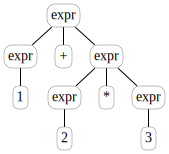

In [ ]:
multprod_parse_tree = MulProd.tree(expr, 'expr', True)
multprod_parse_tree

In [ ]:
# invertendo le alternative per somma e prodotto, si ha la precedenza errata

MulProdWrong = ANTLR(r"""
grammar MulPordWrong; ignoblebug: expr;
 
expr: expr '+' expr
    | expr '*' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

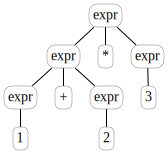

In [ ]:
MulProdWrong.tree(expr, 'expr', True)

### Dangling else

Un altro caso in cui l'ambiguità entra in gioco è quello degli statement `if-else`; il segmento di codice 

In [ ]:
source = ' if e0 then if e1 then i0 else i1'

può infatti essere interpretato (ossia può condurre a un albero di parsing) come

```bash
if e0 then (if e1 then i0 else i1)
```

che è il modo usuale nei linguaggi di programmazione più comuni, che come

```bash
if e0 then (if e1 then i0) else i1
```

In [ ]:
# definiamo un lexer per le parti e… ed i… e per l'usuale whitespace

LEXER = r"""
ISTR: 'i' [0-9]* ;
EXPR: 'e' [0-9]* ;
WS: [ \t\n\r]+ -> skip ;
"""

In [ ]:
# una grammatica che conduce all'associazione dell'else all'if più vicino

IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat
    |   'if' EXPR 'then' stat 'else' stat
    |   ISTR
    ;
    
""" + LEXER)

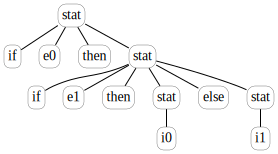

In [ ]:
IfElse.tree(source, 'stat', True)

In [ ]:
# di nuovo, invertendo l'ordine si ottiene un parse "errato"

IfElseWrong = ANTLR(r"""
grammar IfElseWrong;

stat:   'if' EXPR 'then' stat 'else' stat
    |   'if' EXPR 'then' stat
    |   ISTR
    ;
    
""" + LEXER)

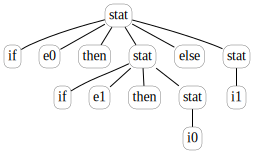

In [ ]:
IfElseWrong.tree(source, 'stat', True)

In [ ]:
# può essere più comoda da ricordare la forma con l'operatore regolare ?

IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat ('else' stat)?
    |   ISTR
    ;
    
""" + LEXER)

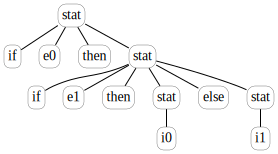

In [ ]:
IfElse.tree(source, 'stat', True)

## Uso di listener e visitor 

Consideriamo un semplice linguaggio di programmazione in cui ci sia una istruzione per riga e le istruzioni possano essere espressioni aritmetiche o assegnamenti di variabile.

In [ ]:
LabeledExpr = ANTLR(r"""
grammar LabeledExpr;

prog:   stat+ ;

stat:   expr NEWLINE                # printExpr
    |   ID '=' expr NEWLINE         # assign
    |   NEWLINE                     # blank
    ;

expr:   expr op=('*'|'/') expr      # MulDiv
    |   expr op=('+'|'-') expr      # AddSub
    |   INT                         # int
    |   ID                          # id
    |   '(' expr ')'                # parens
    ;

MUL :   '*' ; // assigns token name to '*' used above in grammar
DIV :   '/' ;
ADD :   '+' ;
SUB :   '-' ;
ID  :   [a-zA-Z]+ ;      // match identifiers
INT :   [0-9]+ ;         // match integers
NEWLINE:'\r'? '\n' ;     // return newlines to parser (is end-statement signal)
WS : [ \t]+ -> skip ; // toss out whitespace
""")

In [ ]:
# un programma 

prog = """
A = 1
3 + A
B = 2
B + 2 * 3
C = 4
C * C
"""

### Un listener per numerare gli assegnamenti

Supponiamo di voler numerare gli assegnamenti, per fare questo genere di "trasformazioni" che prescindono dall'"interpretazione" del programma, è spesso comodo usare un *listener*

In [ ]:
class LineNumberingListener(LabeledExpr.Listener):
    def __init__(self):
        self.assign_num = 0
    def enterAssign(self, ctx):
        print(self.assign_num, ctx.getText().strip())
        self.assign_num += 1

In [ ]:
# per invocarlo occorre usare un ParseTreeWalker

ctx = LabeledExpr.context(prog, 'prog')
listener = LineNumberingListener()
ParseTreeWalker.DEFAULT.walk(listener, ctx)

0 A=1
1 B=2
2 C=4


### Un visitor per interpretare il programma

Per "interpretare" il programma, ossia per "eseguire" le sue istruzioni, una strada molto comune è quella di usare un *visitor*; nel caso delle foglie, il laovoro da fare è molto semplice, nel caso invece dei nodi interni, il comportamente può essere ottenuto tramite l'invocazione ricorsiva delle funzioni che si occupano di stabilire il comportamento dei sottoalberti.

L'assegnamento a variabile e l'occorrenza della variabile in una sottoespressione richiedono l'uso di una "memoria" che in questo esempio è data da un *dict* (assumeremo che le variabili non ancora assegnate abbiano valore 0).

In [ ]:
class EvalVisitor(LabeledExpr.Visitor):

    def __init__(self):
        self.memory = {} # il dizionario che conserva i valori delle variaibli
    
    # gestione delle variabili
    
    def visitAssign(self, ctx):
        name = ctx.ID().getText()
        value = self.visit(ctx.expr())
        self.memory[name] = value
        return value

    def visitId(self, ctx):
        name = ctx.ID().getText()
        if name in self.memory: return self.memory[name]
        return 0

    # l'unica altra foglia (oltre a ID)
        
    def visitInt(self, ctx):
        return int(ctx.INT().getText())

    # una istruzione con l'effetto collaterale di stampare il valore dell'esrpressione
    
    def visitPrintExpr(self, ctx):
        value = self.visit(ctx.expr())
        print(value)

    # le operazioni aritmetiche e le espressioni parentesizzate

    def visitMulDiv(self, ctx):
        left = self.visit(ctx.expr(0))
        right = self.visit(ctx.expr(1))
        if ctx.op.type == LabeledExpr.Parser.MUL:
            return left * right
        else:
            return left / right

    def visitAddSub(self, ctx):
        left = self.visit(ctx.expr(0))
        right = self.visit(ctx.expr(1))
        if ctx.op.type == LabeledExpr.Parser.ADD:
            return left + right
        else:
            return left - right

    def visitParens(self, ctx):
        return self.visit(ctx.expr())

In [ ]:
# la valutazione si fa direttamente invocando visit

ctx = LabeledExpr.context(prog, 'prog')
visitor = EvalVisitor()
visitor.visit(ctx)

4
8
16


## Un richiamo della "pillola"

Nel seguito risulterà necessario memorizzare delle informazioni necessarie ai processi di traduzione ed interpretazione. 

### Informazione nei nodi

Tali informazioni possono essere memorizzate nell'albero stesso, nel contesto di LibLET noi useremo *alberi con attributi*, ossia alberi in cui `root` non è una stringa, bensì un *dizionario*.

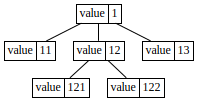

In [ ]:
tree = Tree.from_lol(
    [{'value': 1}, 
           [{'value': 11}], 
           [{'value': 12}, 
               [{'value': 121}], 
               [{'value': 122}]
           ], 
           [{'value': 13}]
       ]
)
tree

#### Attribuiti ereditati

Talvolta i sottoalberti ricevono gli attributi dalla radice (tramite una visita in *pre-ordine*); ad esempio la profondità di un nodo dipende da quella del suo genitore:

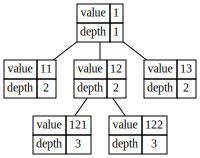

In [ ]:
def update_depth(parent, tree):
    tree.root['depth'] = parent.root['depth'] + 1
    for child in tree.children: update_depth(tree, child)

update_depth(Tree({'depth': 0}), tree)        
tree

#### Attributi sintetizzati

In altri casi, l'attributo della radice deriva da quelli dei sottoalberi (tramite una visita in *post-ordine*); ad esempio il valore massimo del valore nel sottoalbero:

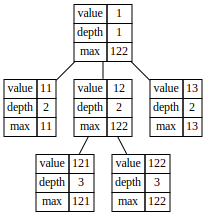

In [ ]:
def update_max(tree):
    if not tree.children: tree.root['max'] = int(tree.root['value'])
    else:
        for child in tree.children: update_max(child)
        tree.root['max'] = max(child.root['max'] for child in tree.children)

update_max(tree)
tree

### Informazione in strutture dati esterne

In altri casi, non è necessario decorare con un valore ogni nodo dell'albero, ma è preferibile usare una struttura dati esterna.

Come esempio, usiamo una lista per raccogliere il massimo valore dei nodi con valore dispari.

In [ ]:
ODD_MAX_NODES = []

def update_ovn(tree):
    if tree.root['max'] % 2 == 1: ODD_MAX_NODES.append(tree.root)
    for child in tree.children: update_ovn(child)
        
update_ovn(tree)

ODD_MAX_NODES

[{'value': 11, 'depth': 2, 'max': 11},
 {'value': 121, 'depth': 3, 'max': 121},
 {'value': 13, 'depth': 2, 'max': 13}]

## Dal *parse tree* all' *abstract syntax tree*

Il *parse tree* è il risultato del parsing.

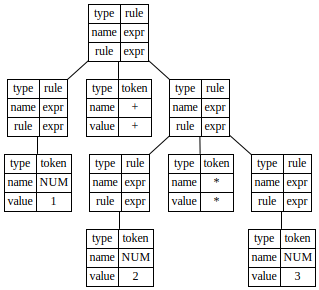

In [ ]:
# parse tree

multprod_parse_tree = MulProd.tree(expr, 'expr')
multprod_parse_tree

l'*AST* è un albero (annotato) che descrive più fedelmente la "semantica" che attribuiamo al linguaggio; nel caso precedente è qualcosa del genere

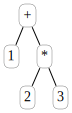

In [ ]:
Tree('+', [Tree(1), Tree('*', [Tree(2), Tree(3)])])

### Derivazione ricorsiva

Il modo più semplice di ottenere l'AST dal parse tree è attraverso una visita ricorsiva del medesimo. In tale visita, al solito, è molto semplice decidere cosa fare per le foglie, mentre per i nodi interni ci si può affidare alla ricorsione.

In [ ]:
def to_ast(tree):
    if tree.children[0].root['type'] == 'token':
        return Tree({'type': 'const', 'value': int(tree.children[0].root['value'])})
    left, op, right = tree.children
    return Tree({'type': 'op', 'kind': op.root['name']}, [to_ast(left), to_ast(right)])

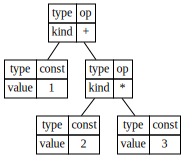

In [ ]:
multprod_ast = to_ast(multprod_parse_tree)    
multprod_ast

### <span style="color: red;">Esempio facoltativo</span>: Costruzione dell'AST durante il parsing

ANTLR mette a disposizione la possibilità di annotare la grammatica con delle "azioni" in modo tale che durante il processo stesso di parsing venga costruito l'AST.

Questo approccio (che qui è mostrato per completezza) è in realtà molto discutibile perché rende la grammatica meno "versatile" dal momento che intruduce in essa segmenti del linguaggio del runtime scelto (in questo caso Python), fatto che rende, ad esempio, la grammatica non utilizzabile con altre runtime (ad esempio Java).

L'unico possibile vantaggio di tale approccio è risparmiare memoria: l'AST è in generale più piccolo del parse tree ed inoltre, in questo modo, il parse tree non viene di fatto mai costruito esplicitamente.

In [ ]:
MulPordAST = ANTLR(r"""
grammar MulPordAST; 

@header {
from liblet import Stack 
}

@members {
    self.STACK = Stack()
}

ignoblebug: expr;

expr: expr '*' expr {self.STACK.push([{'type': 'op', 'kind': '*'}, self.STACK.pop(), self.STACK.pop()])}
    | expr '+' expr {self.STACK.push([{'type': 'op', 'kind': '+'}, self.STACK.pop(), self.STACK.pop()])}
    | NUM {self.STACK.push([{'type': 'const', 'value': $NUM.int}])}
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

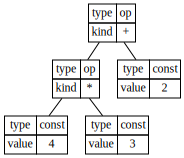

In [ ]:
ctx = MulPordAST.context('2 + 3 * 4', 'expr', build_parse_trees = False)
multprod_ast = Tree.from_lol(ctx.parser.STACK.pop())
multprod_ast

## Uso dell'AST

Una volta ottenuto l'AST, è molto comodo utilizzarlo per i successivi passi di traduzione e/o interpretazione.

### Tramite gli attributi dei nodi

In questo esempio, usiamo una visita ricorsiva in *post-ordine* per annotare ciascun nodo con il valore dell'espressione contenuta nel sottoalbero.

In [ ]:
# il valore è sintetizzato, quindi uso una visita in post-ordine

def update_value(tree):
    if tree.root['type'] == 'op':
        left, right = tree.children
        update_value(left)
        update_value(right)
        if tree.root['kind'] == '+':
            tree.root['value'] = left.root['value'] + right.root['value']
        else:
            tree.root['value'] = left.root['value'] * right.root['value']

In [ ]:
# annoto l'albero

update_value(multprod_ast)

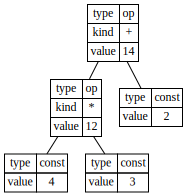

In [ ]:
multprod_ast

In [ ]:
# il valore dell'espressione è nella radice

multprod_ast.root['value']

14

### Tramite una struttura dati esterna

La valutazione dell'espressione può essere ottenuta anche tramite una visita in *pre-ordine* che faccia uso di una *pila* per conservare i risultati intermedi della valutazione.

In [ ]:
def expr_eval(tree):
    if tree.root['type'] == 'op':
        left, right = tree.children
        expr_eval(left)
        expr_eval(right)
        if tree.root['kind'] == '+':
            STACK.push(STACK.pop() + STACK.pop())
        else:
            STACK.push(STACK.pop() * STACK.pop())
    else:
        STACK.push(tree.root['value'])
        

In [ ]:
# valuto l'espressione

STACK = Stack()
expr_eval(multprod_ast)

In [ ]:
# alla fine, il valore è in cima alla pila
STACK.pop()

14